In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

seed = 50
np.random.seed(seed)

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

## Downloading and normalizing Fashion MNIST and CIFAR-10 datasets

In [ ]:
# Define transformations, including vectorization and normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize image
])

root_dir = './data'

fashion_mnist_train = datasets.FashionMNIST(root=root_dir, train=True, download=True, transform=transform)
fashion_mnist_test = datasets.FashionMNIST(root=root_dir, train=False, download=True, transform=transform)

cifar10_train = datasets.CIFAR10(root=root_dir, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root=root_dir, train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 12645838.04it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211953.95it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3713396.64it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20524978.13it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 170498071/170498071 [00:05<00:00, 30852712.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## show Fashion MNIST dataset

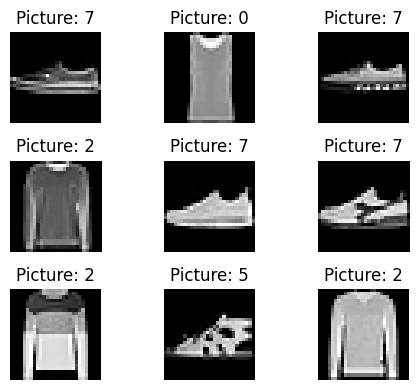

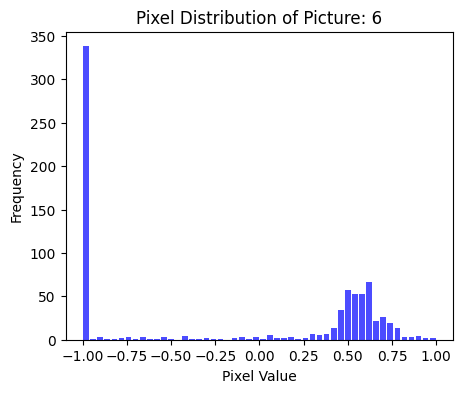

In [ ]:
# show some sample
def show_samples(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=9, shuffle=True)
    dataiter = iter(loader)
    images, labels = next(dataiter)

    plt.figure(figsize=(5,4))
    for i in range(9):
        plt.subplot(3,3,i+1)
        img = images[i] / 2 + 0.5  # unnormalize
        plt.imshow(img[0], cmap='gray')
        plt.title(f"Picture: {labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# show pixel distribution
def plot_pixel_distribution(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    dataiter = iter(loader)
    images, labels = next(dataiter)

    plt.figure(figsize=(5,4))
    plt.hist(images[0].numpy().ravel(), bins=50, color='blue', alpha=0.7, rwidth=0.8)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title(f"Pixel Distribution of Picture: {labels[0].item()}")
    plt.show()

# analyze
show_samples(fashion_mnist_train)
plot_pixel_distribution(fashion_mnist_train)


## show CIFAR10 dataset

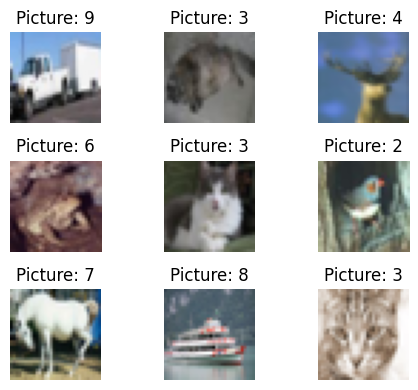

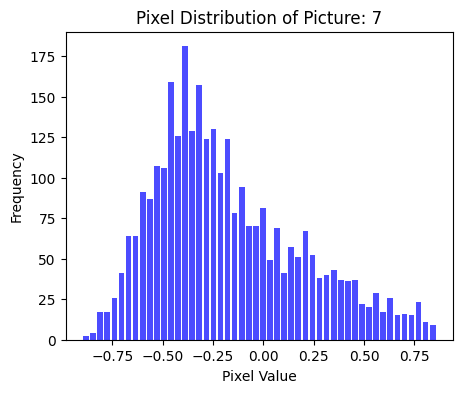

In [ ]:
# show some sample
def show_samples(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=9, shuffle=True)
    dataiter = iter(loader)
    images, labels = next(dataiter)

    plt.figure(figsize=(5,4))
    for i in range(9):
        plt.subplot(3,3,i+1)
        img = images[i] / 2 + 0.5  # unnormalize
        plt.imshow(img.permute(1, 2, 0))  # Rearrange dimensions to be suitable for imshow
        plt.title(f"Picture: {labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# show pixel distribution
def plot_pixel_distribution(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    dataiter = iter(loader)
    images, labels = next(dataiter)

    plt.figure(figsize=(5,4))
    plt.hist(images[0].numpy().ravel(), bins=50, color='blue', alpha=0.7, rwidth=0.8)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title(f"Pixel Distribution of Picture: {labels[0].item()}")
    plt.show()

# analyze
show_samples(cifar10_train)
plot_pixel_distribution(cifar10_train)


## Extracting features and labels from datasets

In [ ]:
# Define a function to extract features and labels
def extract_features_labels(dataset):
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    for images, labels in dataloader:
        # Flatten the image data into a one-dimensional vector
        features = images.view(images.size(0), -1)
        return features, labels

# Extract features and labels
fashion_mnist_train_features, fashion_mnist_train_labels = extract_features_labels(fashion_mnist_train)
fashion_mnist_test_features, fashion_mnist_test_labels = extract_features_labels(fashion_mnist_test)
cifar10_train_features, cifar10_train_labels = extract_features_labels(cifar10_train)
cifar10_test_features, cifar10_test_labels = extract_features_labels(cifar10_test)

## Printing the sizes of features and labels from Fashion MNIST and CIFAR-10 datasets

In [ ]:
print(fashion_mnist_train_features.size())
print(fashion_mnist_train_labels.size())
print(fashion_mnist_test_features.size())
print(fashion_mnist_test_labels.size())

print(cifar10_train_features.size())
print(cifar10_train_labels.size())
print(cifar10_test_features.size())
print(cifar10_test_labels.size())

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])
torch.Size([50000, 3072])
torch.Size([50000])
torch.Size([10000, 3072])
torch.Size([10000])


#### convert to ndarray

- The Fashion MNIST dataset consists of 60,000 training samples and 10,000 testing samples. Each sample has a feature vector length of 784 because each image is 28x28 pixels and has been flattened into a one-dimensional vector¹.

- The CIFAR-10 dataset consists of 50,000 training samples and 10,000 testing samples. Each sample has a feature vector length of 3072 because each image is 32x32 pixels and has 3 color channels (RGB), resulting in a total of 32x32x3 features¹.

In [ ]:
# Convert to ndarray and rename
fm_train_x, fm_train_y = fashion_mnist_train_features.numpy(), fashion_mnist_train_labels.numpy()
fm_test_x, fm_test_y = fashion_mnist_test_features.numpy(), fashion_mnist_test_labels.numpy()
cf_train_x, cf_train_y = cifar10_train_features.numpy(), cifar10_train_labels.numpy()
cf_test_x, cf_test_y = cifar10_test_features.numpy(), cifar10_test_labels.numpy()

def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = np.max(labels) + 1
    return np.eye(num_classes)[labels]


fm_train_y_one_hot = one_hot_encode(fm_train_y)
fm_test_y_one_hot = one_hot_encode(fm_test_y)
cf_train_y_one_hot = one_hot_encode(cf_train_y)
cf_test_y_one_hot = one_hot_encode(cf_test_y)


print(fm_train_x.shape)
print(fm_train_y_one_hot.shape)
print(fm_test_x.shape)
print(fm_test_y_one_hot.shape)
print("--------------------")
print(cf_train_x.shape)
print(cf_train_y_one_hot.shape)
print(cf_test_x.shape)
print(cf_test_y_one_hot.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)
--------------------
(50000, 3072)
(50000, 10)
(10000, 3072)
(10000, 10)


## MLP Model

In [ ]:
"""
Parameters:
    - hidden_layers (int): Number of hidden layers.
    - hidden_units (list of int): Units per hidden layer.
    - activation_function (str, optional): Type of activation ("ReLU", "sigmoid", "leaky_relu", "tanh"). Defaults to "ReLU".
    - init_strategy (str, optional): Weight initialization method ("zeros", "uniform", "gaussian", "xavier", "kaiming"). Defaults to "gaussian".
    - record_history (bool, optional): Whether to record loss during training. Defaults to False.
    - regularization (str, optional): Regularization technique ("l1", "l2", or None). Helps deter overfitting. Defaults to None.
    - lambda_reg (float, optional): Regularization rate, applicable if regularization is used. Defaults to 0.01.
    - learning_rate (float, optional): The rate at which the model adjusts the weights in response to errors. Important for convergence during training. Defaults to a value if not specified.
    - epochs (int, optional): The number of iterations the model goes through the training data. Directly impacts model tuning and performance. Defaults to a value if not specified.
    - batch_size (int, optional): Number of training samples utilized in one iteration. Affects the model's ability to generalize and convergence speed. Defaults to a value if not specified.
    - output_size (int, optional): Number of neurons in the output layer, typically corresponding to the number of classes in a classification task. Defaults to 10.
"""
class MLP:
    def __init__(self, hidden_layers, hidden_units, activation_function="ReLU", init_strategy="gaussian", record_history=False, regularization=None, lambda_reg=0.01, output_size=10, learning_rate=0.001, epochs=1000, batch_size=64):
        self.activation_function = activation_function
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.init_strategy = init_strategy
        self.weights = []
        self.biases = []
        self.activations = []
        self.record_history = record_history
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        if self.record_history:
            self.loss_val = []

    def initialize(self, input_size, output_size):
        layers = [input_size] + self.hidden_units + [output_size]
        for i in range(1, len(layers)):
            if self.init_strategy == "zeros":
                self.weights.append(np.zeros((layers[i], layers[i-1])))
            elif self.init_strategy == "uniform":
                self.weights.append(np.random.uniform(-1, 1, (layers[i], layers[i-1])))
            elif self.init_strategy == "gaussian":
                self.weights.append(np.random.randn(layers[i], layers[i-1]))
            elif self.init_strategy == "xavier":
                self.weights.append(np.random.randn(layers[i], layers[i-1]) * np.sqrt(1. / layers[i-1]))
            elif self.init_strategy == "kaiming":
                self.weights.append(np.random.randn(layers[i], layers[i-1]) * np.sqrt(2. / layers[i-1]))
            else:
                raise ValueError("Invalid initialization strategy!")
            self.biases.append(np.zeros((layers[i], 1)))

    def activation(self, z):
        # Activation function
        if self.activation_function == "ReLU":
            return np.maximum(0, z)
        elif self.activation_function == "sigmoid":
            return 1 / (1 + np.exp(-z))
        elif self.activation_function == "leaky_relu":
            alpha = 0.01  # can adjust this
            return np.where(z > 0, z, alpha * z)
        elif self.activation_function == "tanh":
            return np.tanh(z)
        # Add more activation functions as needed

    def activation_derivative(self, z):
        # Derivative of activation function
        if self.activation_function == "ReLU":
            return np.where(z > 0, 1, 0)
        elif self.activation_function == "sigmoid":
            a = self.activation(z)
            return a * (1 - a)
        elif self.activation_function == "leaky_relu":
            alpha = 0.01  # can adjust this
            return np.where(z > 0, 1, alpha)
        elif self.activation_function == "tanh":
            return 1 - np.tanh(z)**2
        # Add more derivatives as needed

    def softmax(self, z):
        e_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        result = e_z / np.sum(e_z, axis=0, keepdims=True)
        return result


    def forward(self, X):
        self.activations = [X.T]
        a = X.T
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(w, a) + b
            # If it's output layer, use the softmax
            if i == len(self.weights) - 1:
                a = self.softmax(z)
            else:
                a = self.activation(z)
            self.activations.append(a)
        return a

    def loss(self, y, y_pred):
        m = y.shape[1]
        cross_entropy_loss = -1/m * np.sum(y * np.log(y_pred + 1e-10))

        if self.regularization:
            reg_loss = 0
            for w in self.weights:
                if self.regularization == "l1":
                    reg_loss += np.sum(np.abs(w))
                elif self.regularization == "l2":
                    reg_loss += 0.5 * np.sum(np.square(w))
                else:
                    raise ValueError("Invalid regularization type!")

            reg_loss *= self.lambda_reg / m  # averaging by number of samples
            return cross_entropy_loss + reg_loss

        return cross_entropy_loss


    def backward(self, X, y):
        m = X.shape[0]
        grads = {}
        y_pred = self.activations[-1]
        dZ = y_pred - y

        for i in reversed(range(self.hidden_layers + 1)):
            dW = 1/m * np.dot(dZ, self.activations[i].T)

            # Add regularization
            if self.regularization:
                if self.regularization == "l1":
                    dW += self.lambda_reg/m * np.sign(self.weights[i])
                elif self.regularization == "l2":
                    dW += self.lambda_reg/m * self.weights[i]
                else:
                    raise ValueError("Invalid regularization type!")

            dB = 1/m * np.sum(dZ, axis=1, keepdims=True)
            # If not the first hidden layer, compute dZ for the next iteration
            if i != 0:
                dA = np.dot(self.weights[i].T, dZ)
                dZ = dA * self.activation_derivative(self.activations[i])
            grads["dW" + str(i+1)] = dW
            grads["dB" + str(i+1)] = dB
        return grads


    def update(self, grads, learning_rate):
        for i in range(self.hidden_layers + 1):
            self.weights[i] = self.weights[i] - learning_rate * grads["dW" + str(i+1)]
            self.biases[i] = self.biases[i] - learning_rate * grads["dB" + str(i+1)]

    def fit(self, X, y):
        self.initialize(X.shape[1], self.output_size)

        y = y.T
        m = X.shape[0]  # sample size

        for epoch in range(self.epochs):
            # Randomly select a batch of data
            batch_indices = np.random.choice(m, self.batch_size, replace=False)
            X_batch = X[batch_indices, :]
            y_batch = y[:, batch_indices]

            # Forward propagation, calculating loss, back propagation and parameter update
            y_pred = self.forward(X_batch)
            loss = self.loss(y_batch, y_pred)
            grads = self.backward(X_batch, y_batch)
            self.update(grads, self.learning_rate)

            if self.record_history:
                self.loss_val.append(loss)

            # if epoch % 100 == 0:
            #     print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        y_pred = self.forward(X)
        predictions = np.argmax(y_pred, axis=0)
        return predictions.reshape(1, -1)

### Train the MLP model on Fashion MNIST

In [ ]:
# Instantiate the MLP class with the new parameters set here
mlp_model = MLP(
    hidden_layers=2,
    hidden_units=[128, 128],
    activation_function="ReLU",
    init_strategy="kaiming",
    regularization="l2",
    learning_rate=1e-1,
    epochs=1000,
    batch_size=64
)

# Train the model, now the fit method takes only X and y as arguments
mlp_model.fit(
    X=fm_train_x,
    y=fm_train_y_one_hot
)

# Make predictions
predictions_train = mlp_model.predict(fm_train_x)
predictions_test = mlp_model.predict(fm_test_x)

# The function to calculate accuracy remains unchanged
def evaluate_acc(predictions, labels):
    labels_max = np.argmax(labels, axis=1)
    accuracy = np.mean(predictions == labels_max)
    return accuracy * 100

# Calculate and print training and testing accuracies
accuracy_train = evaluate_acc(predictions_train, fm_train_y_one_hot)
accuracy_test = evaluate_acc(predictions_test, fm_test_y_one_hot)

print(f"Training Accuracy: {accuracy_train:.2f}%")
print(f"Testing Accuracy: {accuracy_test:.2f}%")

Training Accuracy: 81.00%
Testing Accuracy: 79.79%


### 3.1

Training with zeros initialization...
Training with uniform initialization...
Training with gaussian initialization...
Training with xavier initialization...
Training with kaiming initialization...


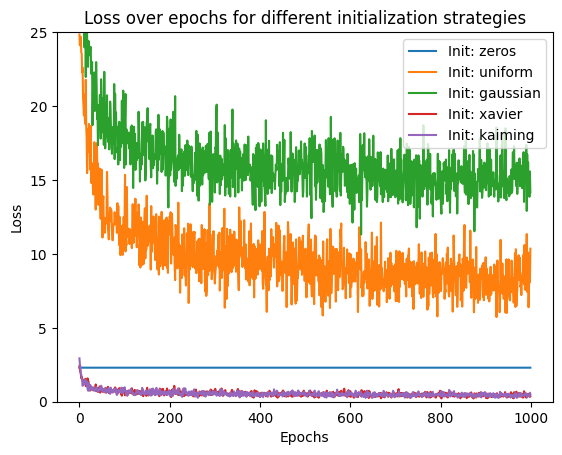

<Figure size 500x400 with 0 Axes>

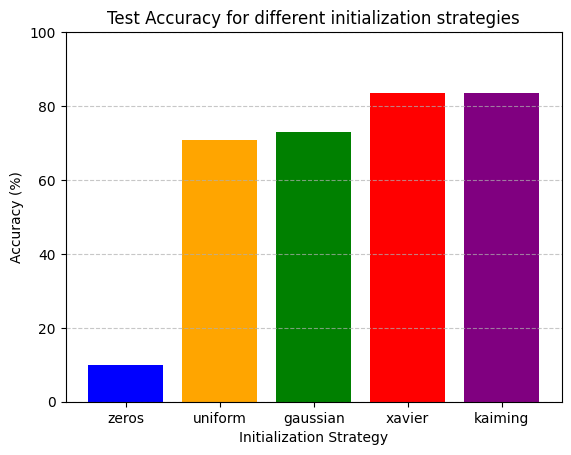

<Figure size 500x400 with 0 Axes>

In [ ]:
# Define initialization strategies and corresponding learning rates
init_strategies = ['zeros', 'uniform', 'gaussian', 'xavier', 'kaiming']
learning_rates = [1e-3, 1e-3, 1e-3, 1e-1, 1e-1]

# To record the loss history and accuracy for each strategy
loss_history = []
accuracy_results = []

# Train for each initialization strategy
for init_strategy, lr in zip(init_strategies, learning_rates):
    print(f"Training with {init_strategy} initialization...")
    mlp_model = MLP(
        hidden_layers=2,
        hidden_units=[128, 128],
        activation_function="ReLU",
        init_strategy=init_strategy,
        regularization="l2",
        learning_rate=lr,
        epochs=1000,
        batch_size=64,
        record_history=True  # Ensure to record loss history
    )

    # Train the model
    mlp_model.fit(fm_train_x, fm_train_y_one_hot)

    # Save the loss history
    loss_history.append(mlp_model.loss_val)

    # Predict and calculate accuracy
    predictions_test = mlp_model.predict(fm_test_x)
    accuracy = evaluate_acc(predictions_test, fm_test_y_one_hot)
    accuracy_results.append(accuracy)

# Plot the loss changes
for idx, loss_val in enumerate(loss_history):
    plt.plot(loss_val, label=f'Init: {init_strategies[idx]}')
plt.title('Loss over epochs for different initialization strategies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,25)
plt.legend()
plt.figure(figsize=(5, 4))
plt.show()

# Plot the accuracy bar chart
plt.bar(init_strategies, accuracy_results, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Initialization Strategy')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy for different initialization strategies')
plt.ylim([0, 100])  # You can adjust this value according to the actual accuracy range
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.figure(figsize=(5, 4))
plt.show()

### 3.2

Training model with 0 hidden layers...
Training model with 1 hidden layers...
Training model with 2 hidden layers...


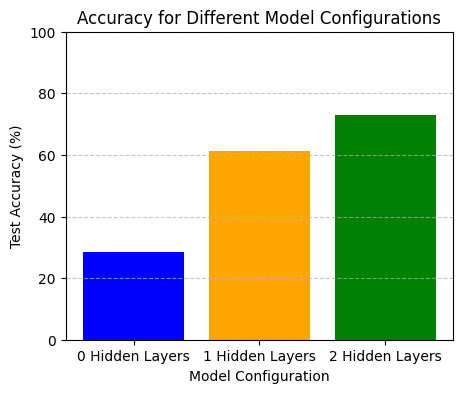

In [ ]:
# Define the configurations of the models to be tested
model_configs = [
    {"hidden_layers": 0, "hidden_units": []},
    {"hidden_layers": 1, "hidden_units": [128]},
    {"hidden_layers": 2, "hidden_units": [128, 128]}
]

# This list will store the accuracy of each model configuration
accuracy_results = []

# Iterating over each configuration, training the respective model, and collecting data
for config in model_configs:
    print(f"Training model with {config['hidden_layers']} hidden layers...")

    # Creating an instance of the MLP model with the current configuration
    mlp_model = MLP(
        hidden_layers=config['hidden_layers'],
        hidden_units=config['hidden_units'],
        activation_function="ReLU",
        init_strategy="gaussian",
        regularization="l2",
        learning_rate=1e-3,
        epochs=1000,
        batch_size=64
        # Assuming the model's fit method captures and stores the loss history internally
    )

    # Training the model
    mlp_model.fit(fm_train_x, fm_train_y_one_hot)

    # Evaluating the model on the test data and storing the accuracy
    predictions = mlp_model.predict(fm_test_x)
    accuracy = evaluate_acc(predictions, fm_test_y_one_hot)
    accuracy_results.append(accuracy)

# Plotting the accuracy of the models
plt.figure(figsize=(5, 4))
config_labels = [f"{config['hidden_layers']} Hidden Layers" for config in model_configs]
plt.bar(config_labels, accuracy_results, color=['blue', 'orange', 'green'])
plt.title('Accuracy for Different Model Configurations')
plt.xlabel('Model Configuration')
plt.ylabel('Test Accuracy (%)')
plt.ylim([0, 100])  # Optionally adjust this based on your accuracies' range
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


### 3.3

Training model with sigmoid activation...
Test accuracy with sigmoid activation: 35.86%

Training model with tanh activation...
Test accuracy with tanh activation: 58.90%

Training model with ReLU activation...
Test accuracy with ReLU activation: 73.51%

Training model with leaky_relu activation...
Test accuracy with leaky_relu activation: 71.54%



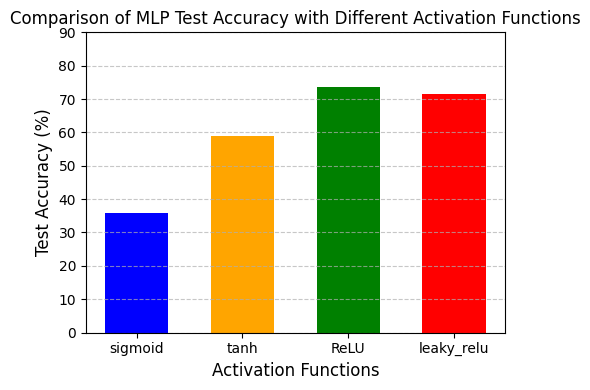

In [ ]:
# Define the different activation functions to test
activation_functions = ["sigmoid", "tanh", "ReLU", "leaky_relu"]

# Store the test accuracies for each activation function
accuracies = []

for activation in activation_functions:
    print(f"Training model with {activation} activation...")

    # Create a new model with the current activation function
    mlp_model = MLP(
        hidden_layers=2,
        hidden_units=[128, 128],
        activation_function=activation,
        init_strategy="gaussian",
        regularization="l2",
        learning_rate=1e-3,
        epochs=1000,
        batch_size=64
    )

    # Train the model
    mlp_model.fit(
        X=fm_train_x,
        y=fm_train_y_one_hot
    )

    # Make predictions on the test set
    predictions_test = mlp_model.predict(fm_test_x)

    # Evaluate the accuracy of the model on the test set
    accuracy_test = evaluate_acc(predictions_test, fm_test_y_one_hot)
    print(f"Test accuracy with {activation} activation: {accuracy_test:.2f}%\n")

    # Store the accuracy in the list
    accuracies.append(accuracy_test)

# Plot the accuracies in a bar chart
labels = activation_functions
pos = np.arange(len(labels))

plt.figure(figsize=(5, 4))  # Adjusting the figure size as per your request

colors = ['blue', 'orange', 'green', 'red']  # Each bar will have a distinct color

plt.bar(pos, accuracies, color=colors, width=0.6)  # The bar chart with specified colors and width

# Adding labels and title to the plot
plt.xlabel('Activation Functions', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Comparison of MLP Test Accuracy with Different Activation Functions', fontsize=12)
plt.xticks(pos, labels, fontsize=10)  # Reduced fontsize to fit in the smaller plot size
plt.ylim([0, 90])  # Assuming the accuracy is in percentage

# Adding grid lines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### 3.4

Training model with None regularization...
Test accuracy with None regularization: 71.84%

Training model with l1 regularization...
Test accuracy with l1 regularization: 73.70%

Training model with l2 regularization...
Test accuracy with l2 regularization: 73.39%



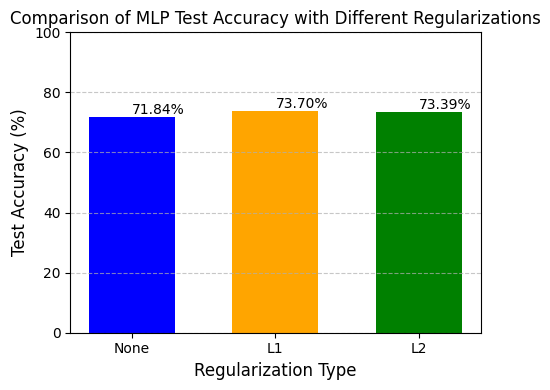

In [ ]:
# Define the different regularization techniques to be tested
regularizations = [None, "l1", "l2"]

# Store the test accuracies for each regularization method
accuracies = []

for regularization in regularizations:
    print(f"Training model with {regularization} regularization...")

    # Create a new model instance with the current regularization method
    mlp_model = MLP(
        hidden_layers=2,
        hidden_units=[128, 128],
        activation_function="ReLU",
        init_strategy="gaussian",
        regularization=regularization,  # current regularization
        learning_rate=1e-3,
        epochs=1000,
        batch_size=64
    )

    # Train the model
    mlp_model.fit(
        X=fm_train_x,
        y=fm_train_y_one_hot
    )

    # Predict on the test set
    predictions_test = mlp_model.predict(fm_test_x)

    # Evaluate the accuracy of the model on the test set
    accuracy_test = evaluate_acc(predictions_test, fm_test_y_one_hot)
    print(f"Test accuracy with {regularization} regularization: {accuracy_test:.2f}%\n")

    # Store the accuracy in the list
    accuracies.append(accuracy_test)

# Now, let's plot the accuracies in a bar chart
labels = ['None', 'L1', 'L2']  # we will use strings, even for None

# Set the positions and width for the bars
pos = np.arange(len(labels))

# Plotting the bar chart
plt.figure(figsize=(5, 4))

colors = ['blue', 'orange', 'green']  # different colors for each bar

bars = plt.bar(pos, accuracies, color=colors, width=0.6)  # create the bar plot with specific colors and a slightly narrower width

# Adding details and labels to the chart
plt.xlabel('Regularization Type', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Comparison of MLP Test Accuracy with Different Regularizations', fontsize=12)
plt.xticks(pos, labels, fontsize=10)  # ensuring the labels fit in a smaller chart size
plt.ylim([0, 100])  # assuming accuracies are in percentage

# Adding grid lines for easier readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adding the data labels at the top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, "%.2f" % yval + '%', va='bottom')  # va: vertical alignment

plt.tight_layout()
plt.show()


### prepare unnormalized data

In [ ]:
# Define transformations, including vectorization and normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

fashion_mnist_train_raw = datasets.FashionMNIST(root=root_dir, train=True, download=False, transform=transform)
fashion_mnist_test_raw = datasets.FashionMNIST(root=root_dir, train=False, download=False, transform=transform)

# Extract features and labels
fashion_mnist_train_features_raw, fashion_mnist_train_labels_raw = extract_features_labels(fashion_mnist_train_raw)
fashion_mnist_test_features_raw, fashion_mnist_test_labels_raw = extract_features_labels(fashion_mnist_test_raw)

# Convert to ndarray and rename
fm_train_x_raw, fm_train_y_raw = fashion_mnist_train_features_raw.numpy(), fashion_mnist_train_labels_raw.numpy()
fm_test_x_raw, fm_test_y_raw = fashion_mnist_test_features_raw.numpy(), fashion_mnist_test_labels_raw.numpy()

fm_train_y_one_hot_raw = one_hot_encode(fm_train_y_raw)
fm_test_y_one_hot_raw = one_hot_encode(fm_test_y_raw)

# print(fm_train_x_raw.shape)
# print(fm_train_y_one_hot_raw.shape)
# print(fm_test_x_raw.shape)
# print(fm_test_y_one_hot_raw.shape)

### 3.5

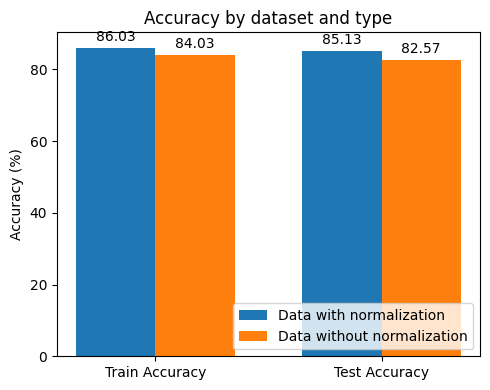

Dataset 1 - Training Accuracy: 86.03%, Testing Accuracy: 85.13%
Dataset 2 - Training Accuracy: 84.03%, Testing Accuracy: 82.57%


In [ ]:
np.random.seed(seed)
def evaluate_acc(predictions, labels):
    labels_max = np.argmax(labels, axis=1)
    accuracy = np.mean(predictions == labels_max)
    return accuracy * 100

# Instantiate and train the model on the first dataset
mlp_model = MLP(hidden_layers=2, hidden_units=[128, 128], activation_function="ReLU",
                init_strategy="kaiming", regularization="l2", learning_rate=1e-1,
                epochs=1000, batch_size=64)

mlp_model.fit(X=fm_train_x, y=fm_train_y_one_hot)
predictions_train = mlp_model.predict(fm_train_x)
predictions_test = mlp_model.predict(fm_test_x)
accuracy_train = evaluate_acc(predictions_train, fm_train_y_one_hot)
accuracy_test = evaluate_acc(predictions_test, fm_test_y_one_hot)

mlp_model = MLP(hidden_layers=2, hidden_units=[128, 128], activation_function="ReLU",
                init_strategy="kaiming", regularization="l2", learning_rate=1e-1,
                epochs=1000, batch_size=64)

# Using the same model instance, train on the second dataset
mlp_model.fit(X=fm_train_x_raw, y=fm_train_y_one_hot_raw)
predictions_train_raw = mlp_model.predict(fm_train_x_raw)
predictions_test_raw = mlp_model.predict(fm_test_x_raw)
accuracy_train_raw = evaluate_acc(predictions_train_raw, fm_train_y_one_hot_raw)
accuracy_test_raw = evaluate_acc(predictions_test_raw, fm_test_y_one_hot_raw)

# Prepare data for the bar chart
labels = ['Train Accuracy', 'Test Accuracy']
dataset1_acc = [accuracy_train, accuracy_test]
dataset2_acc = [accuracy_train_raw, accuracy_test_raw]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Plotting, with the figsize parameter setting the image size
fig, ax = plt.subplots(figsize=(5, 4))  # Setting the width and height of the figure to 5x4 inches

rects1 = ax.bar(x - width/2, dataset1_acc, width, label='Data with normalization')
rects2 = ax.bar(x + width/2, dataset2_acc, width, label='Data without normalization')

# Adding text labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by dataset and type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

# Function to display the values at the top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()  # Automatically adjusts the layout of the plot to fill the figure area
plt.show()  # Display the figure

# Output the results
print(f"Dataset 1 - Training Accuracy: {accuracy_train:.2f}%, Testing Accuracy: {accuracy_test:.2f}%")
print(f"Dataset 2 - Training Accuracy: {accuracy_train_raw:.2f}%, Testing Accuracy: {accuracy_test_raw:.2f}%")

### Train the MLP model on CIFAR-10

In [ ]:
# Instantiate the MLP class with the new parameters set here
mlp_model = MLP(
    hidden_layers=2,
    hidden_units=[256, 256],
    activation_function="ReLU",
    init_strategy="kaiming",
    regularization="l2",
    learning_rate=1e-1,
    epochs=2000,
    batch_size=256
)

# Train the model, now the fit method takes only X and y as arguments
mlp_model.fit(
    X=cf_train_x,
    y=cf_train_y_one_hot
)

# Make predictions
predictions_train = mlp_model.predict(cf_train_x)
predictions_test = mlp_model.predict(cf_test_x)

# The function to calculate accuracy remains unchanged
def evaluate_acc(predictions, labels):
    labels_max = np.argmax(labels, axis=1)
    accuracy = np.mean(predictions == labels_max)
    return accuracy * 100

# Calculate and print training and testing accuracies
accuracy_train = evaluate_acc(predictions_train, cf_train_y_one_hot)
accuracy_test = evaluate_acc(predictions_test, cf_test_y_one_hot)

print(f"Training Accuracy: {accuracy_train:.2f}%")
print(f"Testing Accuracy: {accuracy_test:.2f}%")

Training Accuracy: 66.17%
Testing Accuracy: 51.06%


### Bonus 1: effect of the width on 2 layer MLP

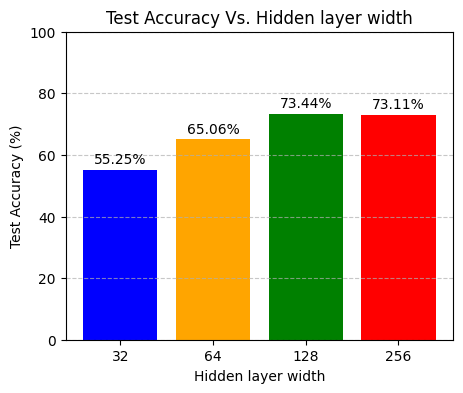

In [ ]:
# Define different hidden unit configurations
hidden_units_configs = [[32, 32], [64, 64], [128, 128], [256, 256]]
test_accuracies = []

# For each configuration, train the model and evaluate test set accuracy
for hidden_units in hidden_units_configs:
    mlp_model = MLP(
        hidden_layers=2,
        hidden_units=hidden_units,
        activation_function="ReLU",
        init_strategy="gaussian",
        regularization="l2",
        learning_rate=1e-3,
        epochs=1000,
        batch_size=64
    )
    mlp_model.fit(X=fm_train_x, y=fm_train_y_one_hot)
    predictions_test = mlp_model.predict(fm_test_x)
    accuracy_test = evaluate_acc(predictions_test, fm_test_y_one_hot)
    test_accuracies.append(accuracy_test)


x_labels = ['32', '64', '128', '256']
plt.figure(figsize=(5, 4))
bars = plt.bar(x_labels, test_accuracies, color=['blue', 'orange', 'green', 'red'])

plt.xlabel('Hidden layer width')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Vs. Hidden layer width')
plt.ylim([0, 100])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding accuracy values on top of the bars
for bar, accuracy in zip(bars, test_accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{accuracy:.2f}%', ha='center', va='bottom')

plt.show()

# CNN Model

In [ ]:
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After pooling, the image size is reduced, adjust dimensions accordingly
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(128, 10)  # The Fashion MNIST has 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 7 * 7)  # Flatten the layer to feed into the fully connected layer

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)  # No activation function is used in the final layer as it will be used with the CrossEntropy loss

        return x

### 3.6

Train the CNN model on FashionMNIST dataset

In [ ]:
def calculate_accuracy(data_loader, model):
    correct_pred = 0
    total_entries = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_pred += (predicted == labels).sum().item()
            total_entries += labels.size(0)
    accuracy = correct_pred / total_entries * 100
    return accuracy

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = CNN_1().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Prepare DataLoader for FashionMNIST dataset
batch_size = 64
train_dataset = datasets.FashionMNIST(root=root_dir, train=True, download=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.FashionMNIST(root=root_dir, train=False, download=False, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Training the model
num_epochs = 5  # You can change the number of epochs as needed
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Clear previous gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f'Epoch {epoch+1}: Loss = {loss.item()}')  # Print loss for each epoch

# After training, we evaluate the model on the training dataset to check for overfitting
train_accuracy = calculate_accuracy(train_loader, model)
print(f'Accuracy on the training set: {train_accuracy:.2f}%')

# Evaluate the model on the test dataset to understand its performance
test_accuracy = calculate_accuracy(test_loader, model)
print(f'Accuracy on the test set: {test_accuracy:.2f}%')

Epoch 1: Loss = 0.27658769488334656
Epoch 2: Loss = 0.3936559855937958
Epoch 3: Loss = 0.728270947933197
Epoch 4: Loss = 0.2570737898349762
Epoch 5: Loss = 0.3394451141357422
Accuracy on the training set: 91.07%
Accuracy on the test set: 89.32%


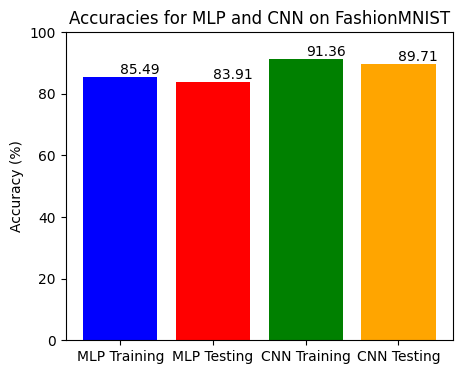

In [ ]:
# Prepare data
labels = ['MLP Training', 'MLP Testing', 'CNN Training', 'CNN Testing']
accuracies = [85.49, 83.91, 91.36, 89.71]  # These are the accuracy figures you provided

# Create bar chart
fig, ax = plt.subplots(figsize=(5, 4))

# Define the parameters for the bars in the chart and draw them
bars = plt.bar(labels, accuracies, color=['blue', 'red', 'green', 'orange'])

# Add numerical labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # va: vertical alignment

# Set the title and labels
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracies for MLP and CNN on FashionMNIST')
ax.set_ylim([0, 100])  # Setting y-axis limit to ensure all labels are visible

# Display the chart
plt.show()

### 3.7

In [ ]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2)


        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 8 * 8)  # Flatten the features for the fully connected layer

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        return x


Train the CNN model on CIFAR10 dataset

In [ ]:
# Prepare data transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# Prepare CIFAR-10 DataLoader
batch_size = 64

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = CNN_2().to(device)  # Ensure this is the modified model

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}: Loss = {loss.item()}')

# Evaluate the model
train_accuracy = calculate_accuracy(train_loader, model)
print(f'Accuracy on the training set: {train_accuracy:.2f}%')

test_accuracy = calculate_accuracy(test_loader, model)
print(f'Accuracy on the test set: {test_accuracy:.2f}%')

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Loss = 1.7207728624343872
Epoch 2: Loss = 0.9771057963371277
Epoch 3: Loss = 1.0988174676895142
Epoch 4: Loss = 1.337073564529419
Epoch 5: Loss = 0.8561039566993713
Epoch 6: Loss = 0.5078157782554626
Epoch 7: Loss = 0.9184417724609375
Epoch 8: Loss = 0.7426177263259888
Epoch 9: Loss = 0.4587794840335846
Epoch 10: Loss = 0.6090857982635498
Accuracy on the training set: 73.18%
Accuracy on the test set: 70.76%


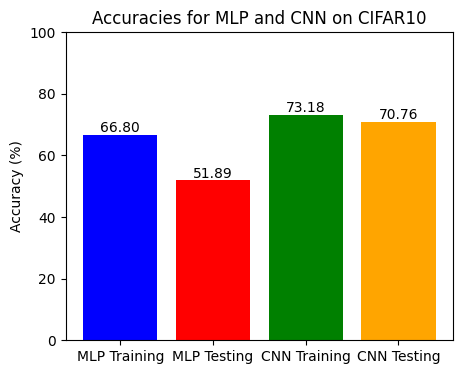

In [ ]:
# Data preparation
labels = ['MLP Training', 'MLP Testing', 'CNN Training', 'CNN Testing']
accuracies = [66.80, 51.89, 73.18, 70.76]  # Updated accuracy figures

# Create a bar chart
fig, ax = plt.subplots(figsize=(5, 4))

# Create bars with the given data and a color for each bar
bars = ax.bar(labels, accuracies, color=['blue', 'red', 'green', 'orange'])

# Add data labels on each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            '%.2f' % float(height),
            ha='center', va='bottom')  # ha is horizontal alignment

# Setting labels and title
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracies for MLP and CNN on CIFAR10')
ax.set_ylim([0, 100])  # Setting y-axis limit for better visualization

# Show the plot
plt.show()


### 3.8

In [ ]:
# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model instantiation
model = CNN_2().to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Parameter settings
optim_configs = [
    {'optimizer': optim.SGD, 'lr': 0.01, 'momentum': 0},
    {'optimizer': optim.SGD, 'lr': 0.01, 'momentum': 0.5},
    {'optimizer': optim.SGD, 'lr': 0.01, 'momentum': 0.9},
    {'optimizer': optim.Adam, 'lr': 0.001}
]

# Prepare to store results
loss_lists = []
accuracy_results = []

def calculate_accuracy(data_loader, model):
    total = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Start training
num_epochs = 10

for config in optim_configs:
    model = CNN_2().to(device)

    optimizer_parameters = {}
    optimizer_parameters['lr'] = config['lr']
    if 'momentum' in config and config['optimizer'] == optim.SGD:
        optimizer_parameters['momentum'] = config['momentum']

    optimizer = config['optimizer'](model.parameters(), **optimizer_parameters)

    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        average_loss = running_loss / len(train_loader)
        loss_history.append(average_loss)
        print(f"Config: {config}, Epoch: {epoch + 1}, Loss: {average_loss}")

    loss_lists.append(loss_history)

    accuracy = calculate_accuracy(test_loader, model)
    accuracy_results.append(accuracy)
    print(f"Config: {config}, Test Accuracy: {accuracy}")

# Results
loss_SGD_0, loss_SGD_05, loss_SGD_09, loss_Adam = loss_lists
accuracy_SGD_0, accuracy_SGD_05, accuracy_SGD_09, accuracy_Adam = accuracy_results

# Output results
# print("Loss lists:", loss_SGD_0, loss_SGD_05, loss_SGD_09, loss_Adam)
# print("Test accuracies:", accuracy_SGD_0, accuracy_SGD_05, accuracy_SGD_09, accuracy_Adam)


Files already downloaded and verified
Files already downloaded and verified
Config: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'momentum': 0}, Epoch: 1, Loss: 2.0782217218747836
Config: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'momentum': 0}, Epoch: 2, Loss: 1.7025569643815766
Config: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'momentum': 0}, Epoch: 3, Loss: 1.5000010225778955
Config: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'momentum': 0}, Epoch: 4, Loss: 1.3708193378375315
Config: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'momentum': 0}, Epoch: 5, Loss: 1.286287508504775
Config: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'momentum': 0}, Epoch: 6, Loss: 1.2199952544458688
Config: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'momentum': 0}, Epoch: 7, Loss: 1.1600338207638783
Config: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'momentum': 0}, Epoch: 8, Loss: 1.10814038917536

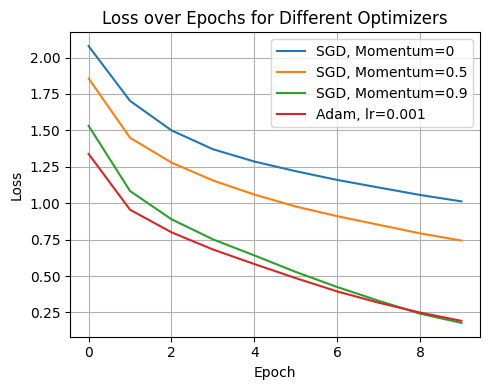

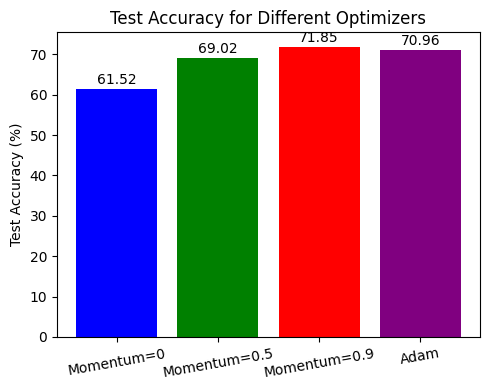

In [ ]:
# Plotting the loss change curve
plt.figure(figsize=(5, 4))

# Plotting the loss curve for each configuration
plt.plot(loss_SGD_0, label='SGD, Momentum=0')
plt.plot(loss_SGD_05, label='SGD, Momentum=0.5')
plt.plot(loss_SGD_09, label='SGD, Momentum=0.9')
plt.plot(loss_Adam, label='Adam, lr=0.001')

# Adding legend, title and labels
plt.legend()
plt.title('Loss over Epochs for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Displaying the figure
plt.tight_layout()
plt.show()

# Data preparation
accuracies = [accuracy_SGD_0, accuracy_SGD_05, accuracy_SGD_09, accuracy_Adam]
config_labels = ['Momentum=0', 'Momentum=0.5', 'Momentum=0.9', 'Adam']

# Plotting the bar chart
plt.figure(figsize=(5, 4))

# Adding the bar chart
plt.bar(config_labels, accuracies, color=['blue', 'green', 'red', 'purple'])

# Adding title and labels
plt.title('Test Accuracy for Different Optimizers')
plt.xticks(rotation=10)
plt.ylabel('Test Accuracy (%)')

# Adding value labels for each bar
for i in range(len(accuracies)):
    plt.text(i, accuracies[i] + 0.5, f'{accuracies[i]:.2f}', ha = 'center', va = 'bottom')  # Place the value label a bit above the bar

# Displaying the figure
plt.tight_layout()
plt.show()

## Bonus 2:  effect of kernel size

In [ ]:
class CNN_1(nn.Module):
    def __init__(self, kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu1 = nn.ReLU()

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After pooling, the image size is reduced, adjust dimensions accordingly
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(128, 10)  # The Fashion MNIST has 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 7 * 7)  # Flatten the layer to feed into the fully connected layer

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)  # No activation function is used in the final layer as it will be used with the CrossEntropy loss

        return x


def calculate_accuracy(data_loader, model):
    correct_pred = 0
    total_entries = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_pred += (predicted == labels).sum().item()
            total_entries += labels.size(0)
    accuracy = correct_pred / total_entries * 100
    return accuracy

# Prepare DataLoader for FashionMNIST dataset
batch_size = 64
train_dataset = datasets.FashionMNIST(root=root_dir, train=True, download=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Prepare DataLoader for FashionMNIST dataset
test_dataset = datasets.FashionMNIST(root=root_dir, train=False, download=False, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = [CNN_1(kernel_size=ks).to(device) for ks in [1, 3, 5, 7]]

# 定义核大小和对应的测试精度
kernel_sizes = ['1x1', '3x3', '5x5', '7x7']

test_accuracies = []
for model in models:
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Training the model
    num_epochs = 5  # You can change the number of epochs as needed
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()  # Clear previous gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

        print(f'Model with kernel size {kernel_sizes[models.index(model)]}, Epoch {epoch+1}: Loss = {loss.item()}')  # Print loss for each epoch

    # Evaluate the model on the test dataset to understand its performance
    test_accuracy = calculate_accuracy(test_loader, model)
    test_accuracies.append(test_accuracy)

Model with kernel size 1x1, Epoch 1: Loss = 0.3126955032348633
Model with kernel size 1x1, Epoch 2: Loss = 0.304573118686676
Model with kernel size 1x1, Epoch 3: Loss = 0.32179152965545654
Model with kernel size 1x1, Epoch 4: Loss = 0.0685414969921112
Model with kernel size 1x1, Epoch 5: Loss = 0.37250471115112305
Model with kernel size 3x3, Epoch 1: Loss = 0.5118193030357361
Model with kernel size 3x3, Epoch 2: Loss = 0.31540027260780334
Model with kernel size 3x3, Epoch 3: Loss = 0.18764324486255646
Model with kernel size 3x3, Epoch 4: Loss = 0.36335489153862
Model with kernel size 3x3, Epoch 5: Loss = 0.09458132833242416
Model with kernel size 5x5, Epoch 1: Loss = 0.2581329345703125
Model with kernel size 5x5, Epoch 2: Loss = 0.5584489107131958
Model with kernel size 5x5, Epoch 3: Loss = 0.39336445927619934
Model with kernel size 5x5, Epoch 4: Loss = 0.2028253674507141
Model with kernel size 5x5, Epoch 5: Loss = 0.4216022491455078
Model with kernel size 7x7, Epoch 1: Loss = 0.533435

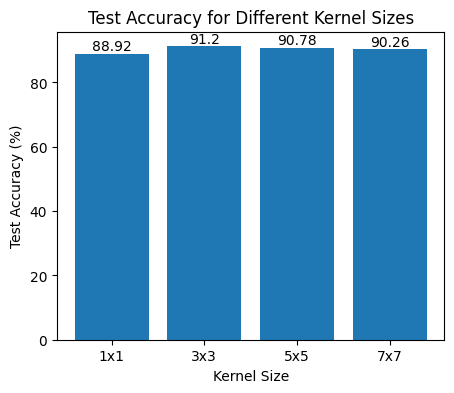

In [ ]:
plt.figure(figsize=(5, 4))
bars = plt.bar(np.arange(len(kernel_sizes)), test_accuracies, tick_label=kernel_sizes)


for bar, accuracy in zip(bars, test_accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(accuracy, 2), ha='center', va='bottom')

plt.xlabel('Kernel Size')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy for Different Kernel Sizes')
plt.show()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet's pre-trained model requires 224x224 input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

def train_and_evaluate(num_layers):
    # Load pre-trained ResNet model
    resnet = models.resnet18(pretrained=True).to(device)  # Move model to GPU
    # Freeze convolutional layers
    for param in resnet.parameters():
        param.requires_grad = False

    # Modify fully connected layers
    layers = []
    in_features = resnet.fc.in_features
    for i in range(num_layers):
        out_features = 256 if i != num_layers - 1 else 10  # The last layer has 10 output features for CIFAR-10 classes
        layers.append(nn.Linear(in_features, out_features))
        if i != num_layers - 1:  # No ReLU after the last layer
            layers.append(nn.ReLU())
        in_features = out_features  # Update in_features for the next layer

    resnet.fc = nn.Sequential(*layers).to(device)  # Move new fully connected layers to GPU

    # Train the model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnet.fc.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)  # Move inputs and labels to GPU
            optimizer.zero_grad()
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

    # Evaluate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)  # Move images and labels to GPU
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy with {num_layers} fully connected layers: {accuracy}%')
    return accuracy

# Train and evaluate models with different fully connected layers
accuracies = {num_layers: train_and_evaluate(num_layers) for num_layers in [2, 6, 10]}


Using device: cuda


100%|██████████| 170498071/170498071 [00:03<00:00, 43651771.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


Epoch 1, Loss: 0.7691590413260643
Epoch 2, Loss: 0.6072776032149639
Epoch 3, Loss: 0.566370072114803
Epoch 4, Loss: 0.533724130610066
Epoch 5, Loss: 0.5058833075606305
Epoch 6, Loss: 0.4812401572571081
Epoch 7, Loss: 0.463980134814749
Epoch 8, Loss: 0.4439115001608039
Epoch 9, Loss: 0.4233332961187948
Epoch 10, Loss: 0.4071664543979613
Accuracy with 2 fully connected layers: 80.45%
Epoch 1, Loss: 1.3975436029684207
Epoch 2, Loss: 0.6956842547792303
Epoch 3, Loss: 0.6231960247239798
Epoch 4, Loss: 0.5823013995919386
Epoch 5, Loss: 0.5484423931983425
Epoch 6, Loss: 0.5282848687923473
Epoch 7, Loss: 0.49878457045692315
Epoch 8, Loss: 0.48097715479181247
Epoch 9, Loss: 0.4638330645459082
Epoch 10, Loss: 0.43791190056544743
Accuracy with 6 fully connected layers: 80.3%
Epoch 1, Loss: 2.303184112624439
Epoch 2, Loss: 2.3028655591828135
Epoch 3, Loss: 2.289295788463729
Epoch 4, Loss: 1.6739675736488284
Epoch 5, Loss: 1.26578838822177
Epoch 6, Loss: 0.8379140470720008
Epoch 7, Loss: 0.72804964

# hyperparameters


choice of hyperparameters in our test:

For MLP:

| Parameter           | Value         |
|---------------------|---------------|
| Hidden Layers       | 2             |
| Units per Layer     | 128, 128      |
| Activation Function | ReLU          |
| Initialization      | Kaiming       |
| Regularization      | L2            |
| Learning Rate       | 1e-1          |
| Epochs              | 1000          |
| Batch Size          | 64            |

For CNN:

| Parameter          | Value      |
|--------------------|------------|
| Learning Rate      | 0.01       |
| Optimizer          | SGD        |
| Momentum           | 0.9        |
| Loss Function      | CrossEntropy|
| Batch Size         | 64         |
| Number of Epochs   | 5          |
| Conv1 In Channels       | 1          |
| Conv1 Out Channels      | 32         |
| Conv1 Kernel Size       | 3x3        |
| Conv2 Out Channels      | 64         |
| Conv2 Kernel Size       | 3x3        |
| Pooling Kernel Size     | 2x2        |
| FC1 In Features         | 64 * 7 * 7 |
| FC1 Out Features        | 128        |
| FC2 Out Features        | 10         |